In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# Make sure we're in the right directory
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

In [80]:
import xarray as xr
import numpy as np
from typing import *
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import colors
import matplotlib.pyplot as plt
from aibedo.utilities.plotting import data_snapshots_plotting, data_mean_plotting
from aibedo.utilities.wandb_api import reload_checkpoint_from_wandb

In [6]:
plt.rcParams['figure.figsize'] = [80, 15]  # general matplotlib parameters
plt.rcParams['figure.dpi'] = 120 

In [7]:
num_workers = 2
test_set = "era5"
DATA_DIR = "./data"

overrides = [f'datamodule.num_workers={num_workers}',
             f'datamodule.partition={[0.85, 0.15, test_set]}',
             'datamodule.eval_batch_size=30',
             'verbose=False',
             f'datamodule.data_dir={DATA_DIR}'
            ]

In [8]:
cur_run_id = None
def get_model_and_dm_from_run_id(run_id):
    global cur_run_id
    cur_run_id = run_id
    values = reload_checkpoint_from_wandb(run_id=run_id, project='AIBEDO', override_key_value=overrides, try_local_recovery=False)
    return  values['model'], values['datamodule'], values['config']

In [9]:
def get_predictions_xarray(run_id, split='predict', return_normalized_outputs=False, variables='all'):
    model, dm, cfg = get_model_and_dm_from_run_id(run_id)
    print('physics_loss_weights:', cfg.model.physics_loss_weights)
    dm.setup(stage=split)
    dataloader = dm.val_dataloader() if 'val' in split else dm.predict_dataloader()
    predictions_xarray = dm.get_predictions_xarray(model, dataloader=dataloader, return_normalized_outputs=return_normalized_outputs, variables=variables)
    del model, dm, cfg
    return predictions_xarray

# Reload and predict with some models:
#### Baseline MLP, without any constraints

In [10]:
rid_baseline = "37z9auhs"
ds_mlp = get_predictions_xarray(rid_baseline)

physics_loss_weights: [0.0, 0.0, 0.0, 0.0, 0.0]


#### Baseline SUNet, without any constraints

In [11]:
rid_sunet_base = "2frxrgnq"
ds_sunet = get_predictions_xarray(rid_sunet_base)

physics_loss_weights: [0.0, 0.0, 0.0, 0.0, 0.0]


#### MLP with constraints

*Note: the MLP with constraints likely does not have the best coefficients for the physics losses*

In [13]:
rid_all= "2ymsmghz"
ds_all_constraints_mlp = get_predictions_xarray(rid_all, split='predict')

physics_loss_weights: [0.0, 0.0, 100.0, 1.0, 0.0001]


In [14]:
snapshots = [1, 10, -50, -45, -38, -36]   # which timesteps to plot
pkwargs = dict(snapshots_to_plot=snapshots, vars_to_plot=['pr'], same_colorbar_for_preds_and_targets=False, robust=False, marker_size=1, coastlines_linewidth=0.5)  # plotting kwargs
ds_mlp_masked, ds_all_constraints_mlp_masked, ds_sunet_masked = ds_mlp.copy(), ds_all_constraints_mlp.copy(), ds_sunet.copy()   # some copies of the xarray preds/targets to play with

### Negative precipitation predictions of no-constraint MLP and SUNet

In [15]:
print("Total #negative precip. in no-constraint-MLP, no-constraint-SUNet, targets, constraint MLP:\t",
      np.count_nonzero(ds_mlp.pr_preds.values < 0), '\t',
      np.count_nonzero(ds_sunet.pr_preds.values < 0), '\t',
      np.count_nonzero(ds_all_constraints_mlp.pr_preds.values < 0), '\t',
      np.count_nonzero(ds_all_constraints_mlp.pr_targets.values < 0))

Total #negative precip. in no-constraint-MLP, no-constraint-SUNet, targets, constraint MLP:	 288912 	 421470 	 0 	 0


# Global maps of precipitation


The predictions are for 5 arbitrary snapshots of the ERA5 test set
- First row: Targets 
- 2nd row: Predictions of MLP without constraints
- 3d row: Predictions of SUNet without constraints
- 4d row: Predictions of MLP with constraints

In [97]:
vmin1 = vmax1 = vmin2 = vmax2 = vmin3 = vmax3 = vmin4 = vmax4 = None  # dummy vars

#### ***Important Note:*** 


All the cells below this one should be **re-run twice** (so that all plots have the same colorbar). That is, if you get an assertion error (normal in the first run of each cell), please rerun the same cell again

#### Where does SUnet or MLP predict negative precip ?

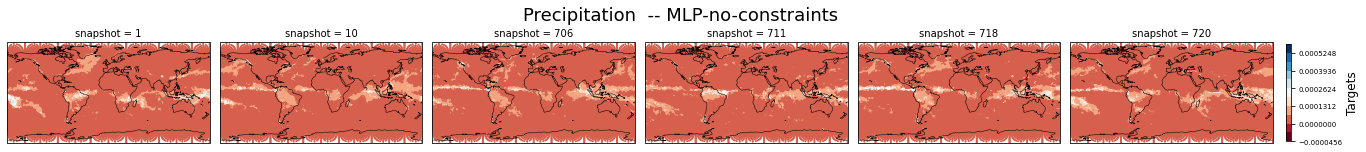

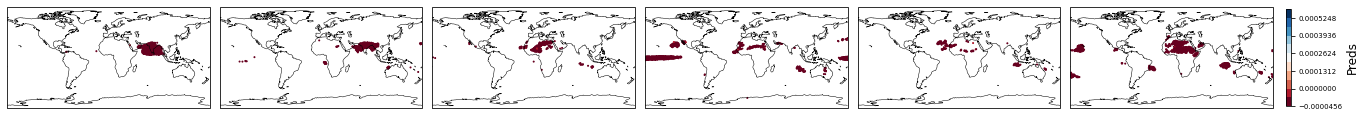

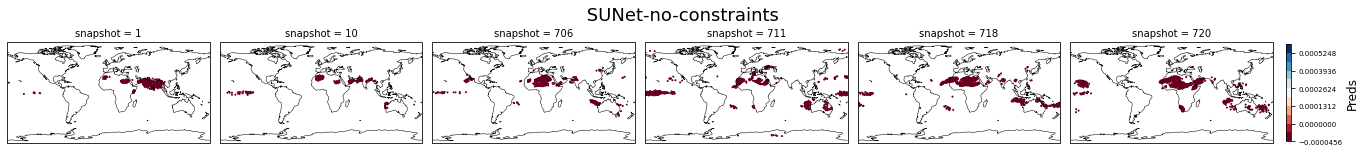

In [75]:
# Mask preds/targets based on where the no-constraint MLP/SUNet predicts pr < 0
ds_mlp_masked['pr_targets'] = ds_mlp['pr_targets']
ds_mlp_masked['pr_preds'] = ds_mlp.pr_preds.where(ds_mlp.pr_preds < 0)
ds_sunet_masked['pr_preds'] = ds_sunet.pr_preds.where(ds_sunet.pr_preds < 0)
cmap= "RdBu"  # cm.get_cmap('RdBu', 6)
N = 10
pkwargs2 = dict(cmap=cmap, norm=mpl.colors.BoundaryNorm([vmin1, -1e-8] + list(np.linspace(0, vmax1, N)), N+1) if vmin1 else None) 
pcs11 = data_snapshots_plotting(ds_mlp_masked, title=" -- MLP-no-constraints", plot_error=False, **pkwargs, **pkwargs2)
pcs12 = data_snapshots_plotting(ds_sunet_masked, title=" SUNet-no-constraints", plot_only_preds=True, **pkwargs, **pkwargs2)

cbar11p, cbar11t, cbar12p = pcs11['pr']['preds'].cbar, pcs11['pr']['targets'].cbar, pcs12['pr']['preds'].cbar
vmin1 = min(cbar11p.vmin, cbar12p.vmin)
vmax1 = pcs11['pr']['targets'].cbar.vmax
assert cbar11p.vmin == cbar11t.vmin and cbar12p.vmax == cbar11t.vmax

### What do the models predict in the locations where no-constraint-MLP predicts negative precipitation?

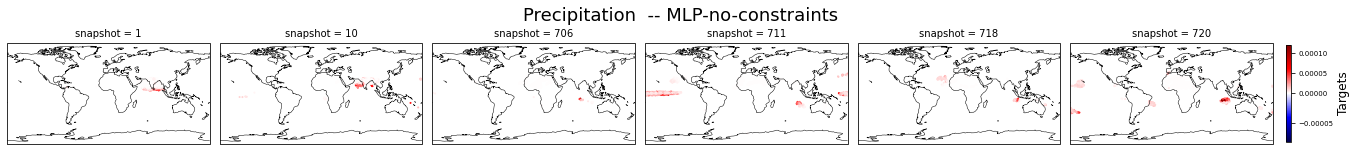

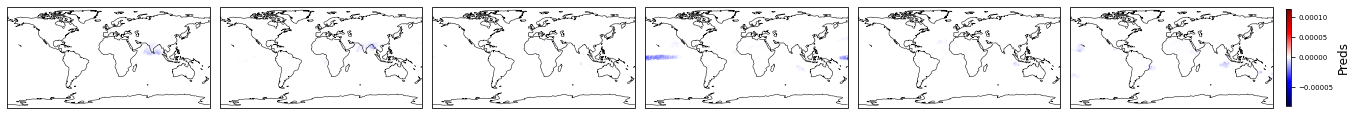

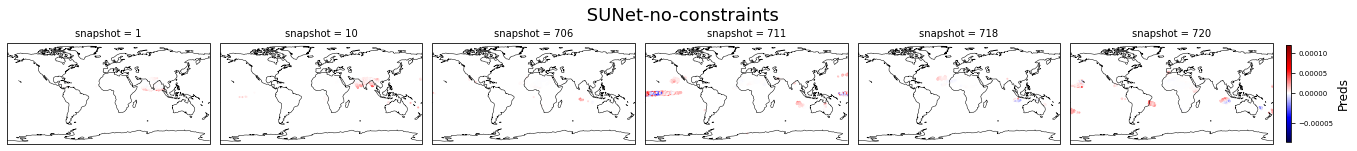

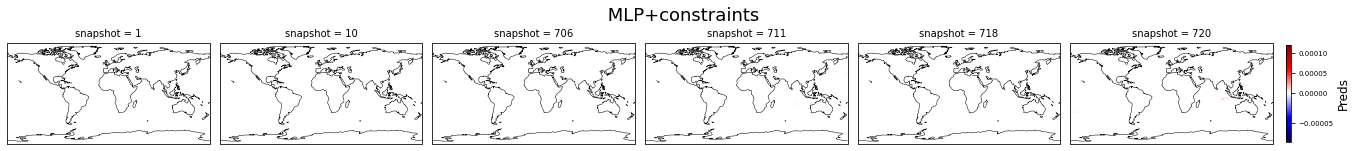

In [91]:
# Mask preds/targets based on where the no-constraint MLP predicts pr < 0
ds_mlp_masked['pr_preds'] = ds_mlp.pr_preds.where(ds_mlp.pr_preds < 0)
ds_mlp_masked['pr_targets'] = ds_mlp.pr_targets.where(ds_mlp.pr_preds < 0)
ds_sunet_masked['pr_preds'] = ds_sunet.pr_preds.where(ds_mlp.pr_preds < 0)
ds_all_constraints_mlp_masked['pr_preds'] = ds_all_constraints_mlp.pr_preds.where(ds_mlp.pr_preds < 0)

cmap='seismic'
pkwargs2 = dict(cmap=cmap, norm=colors.TwoSlopeNorm(vmin=vmin2, vcenter=0.0, vmax=vmax2) if vmin2 else None) 
pcs21 = data_snapshots_plotting(ds_mlp_masked, title=" -- MLP-no-constraints", plot_error=False, **pkwargs, **pkwargs2)
pcs22 = data_snapshots_plotting(ds_sunet_masked, title=" SUNet-no-constraints", plot_only_preds=True, **pkwargs, **pkwargs2)
pcs23 = data_snapshots_plotting(ds_all_constraints_mlp_masked, title=" MLP+constraints", plot_only_preds=True, **pkwargs, **pkwargs2)

cbar21p, cbar21t, cbar22p, cbar23p = pcs21['pr']['preds'].cbar, pcs21['pr']['targets'].cbar, pcs22['pr']['preds'].cbar, pcs23['pr']['preds'].cbar
vmin2 = min(cbar21p.vmin, cbar22p.vmin)
vmax2 = max(cbar21t.vmax, cbar23p.vmax)
assert cbar21p.vmin == cbar21t.vmin and cbar22p.vmax == cbar21t.vmax and cbar22p.vmax == cbar23p.vmax

#### The same as above but for the locations where the SUNet predicts negative pr.

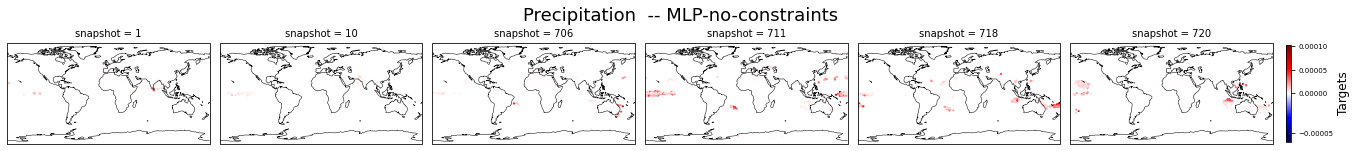

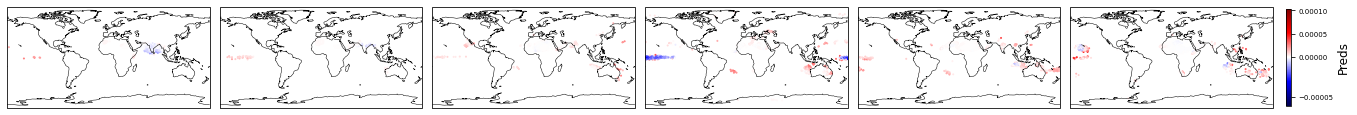

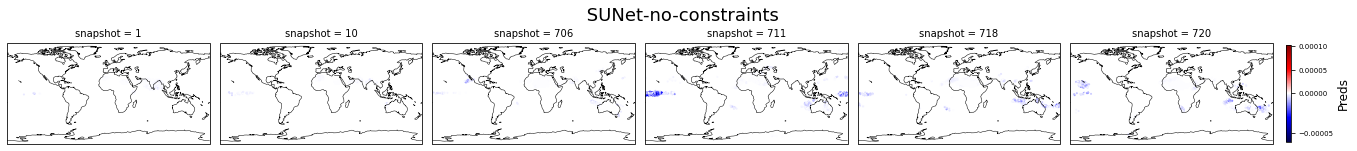

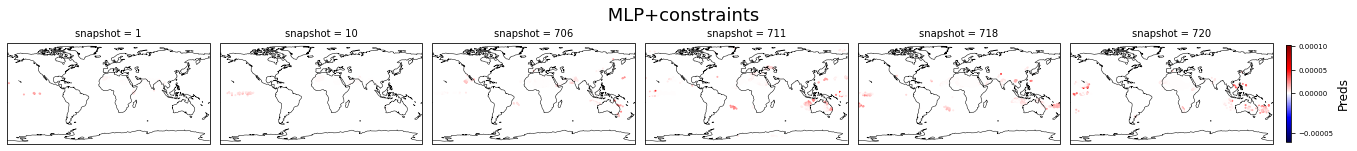

In [96]:
# Mask preds/targets based on where the no-constraint SUNet predicts pr < 0
ds_mlp_masked['pr_preds'] = ds_mlp.pr_preds.where(ds_sunet.pr_preds < 0)
ds_mlp_masked['pr_targets'] = ds_mlp.pr_targets.where(ds_sunet.pr_preds < 0)
ds_sunet_masked['pr_preds'] = ds_sunet.pr_preds.where(ds_sunet.pr_preds < 0)
ds_all_constraints_mlp_masked['pr_preds'] = ds_all_constraints_mlp.pr_preds.where(ds_sunet.pr_preds < 0)

cmap = 'seismic'
pkwargs2 = dict(cmap=cmap, norm=colors.TwoSlopeNorm(vmin=vmin3, vcenter=0.0, vmax=vmax3) if vmin3 else None) 

pcs31 = data_snapshots_plotting(ds_mlp_masked, title=" -- MLP-no-constraints", plot_error=False, **pkwargs, **pkwargs2)
pcs32 = data_snapshots_plotting(ds_sunet_masked, title=" SUNet-no-constraints", plot_only_preds=True, **pkwargs, **pkwargs2)
pcs33 = data_snapshots_plotting(ds_all_constraints_mlp_masked, title=" MLP+constraints", plot_only_preds=True, **pkwargs, **pkwargs2)

cbar31p, cbar31t, cbar32p, cbar33p = pcs31['pr']['preds'].cbar, pcs31['pr']['targets'].cbar, pcs32['pr']['preds'].cbar, pcs33['pr']['preds'].cbar
vmin3 = min(cbar31p.vmin, cbar32p.vmin)
vmax3 = max(cbar31t.vmax, cbar33p.vmax)
assert cbar31p.vmin == cbar31t.vmin and cbar32p.vmax == cbar31t.vmax and cbar32p.vmax == cbar33p.vmax